Original code: https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend

Dataset (GTZAN): https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

# 오디오 파일 이해하기

- y: 소리가 떨리는 세기(진폭)를 시간 순서대로 나열한 것
- Sampling rate: 1초당 샘플의 개수, 단위 Hz 또는 kHz

In [1]:
import librosa

y, sr = librosa.load('Data/genres_original/reggae/reggae.00036.wav')

print(y)
print(len(y))
print('Sampling rate (Hz): %d' % sr)
print('Audio length (seconds): %.2f' % (len(y) / sr))

[0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388]
661794
Sampling rate (Hz): 22050
Audio length (seconds): 30.01


## 음악 들어보기

In [2]:
import IPython.display as ipd

ipd.Audio(y, rate=sr)

## 2D 음파 그래프

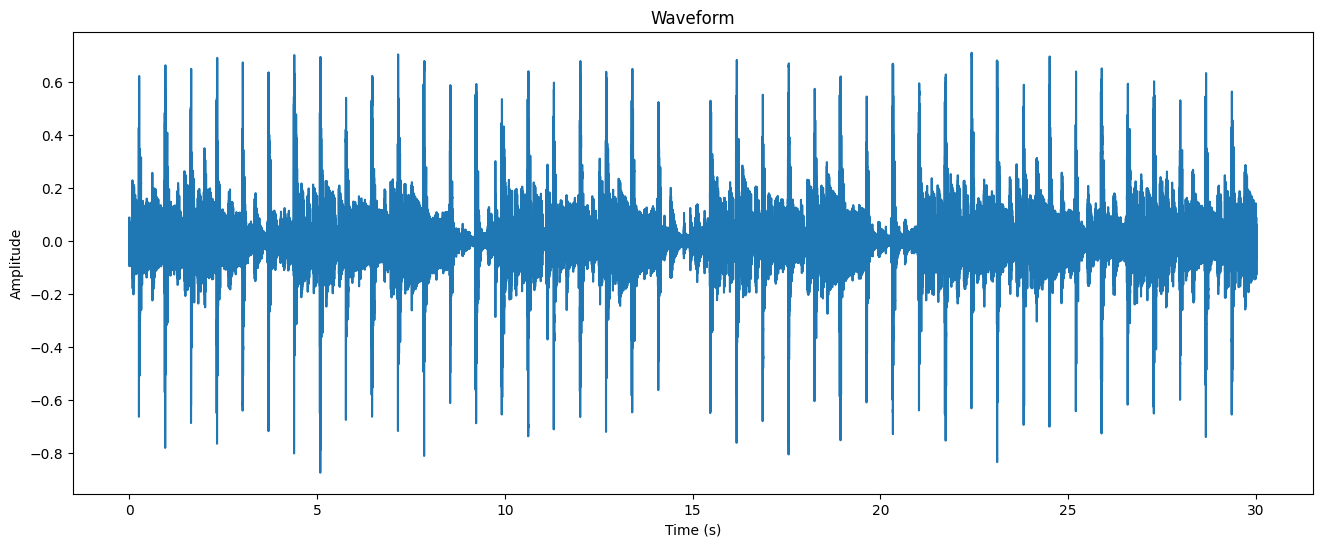

In [3]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

times = np.arange(len(y)) / sr

plt.figure(figsize=(16, 6))
plt.plot(times, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

## Fourier Transform

- 시간 영역 데이터를 주파수 영역으로 변경
- y축: 주파수 (로그 스케일)
- color축: 데시벨 (진폭)

(1025, 1293)


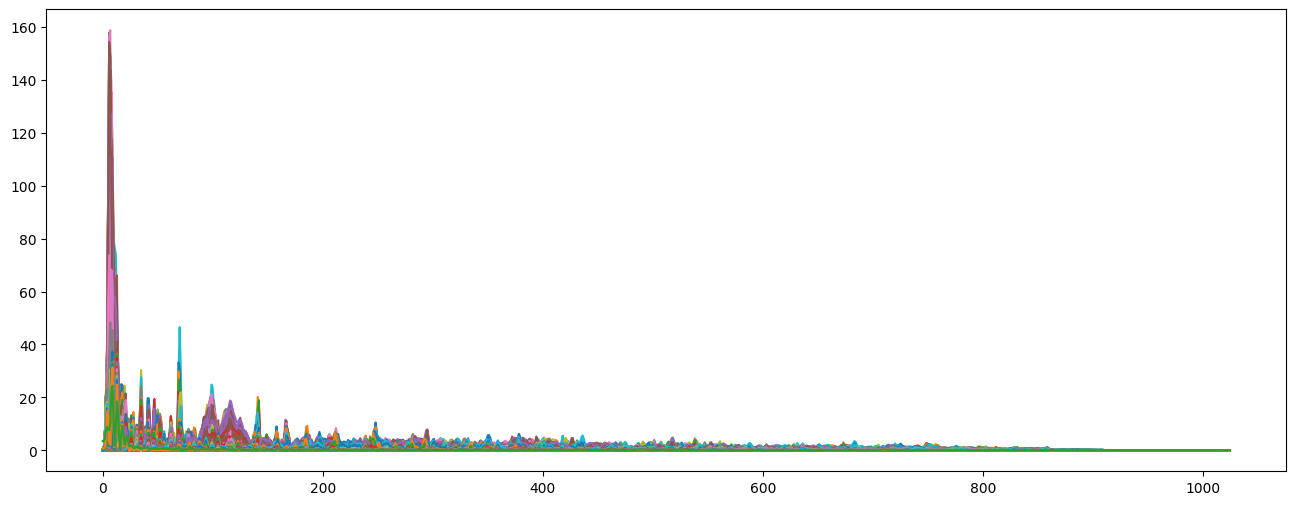

In [4]:
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))

print(D.shape)

plt.figure(figsize=(16, 6))
plt.plot(D)
plt.show()

## Spectogram

- 시간에 따른 신호 주파수의 스펙트럼 그래프
- 다른 이름: Sonographs, Voiceprints, Voicegrams

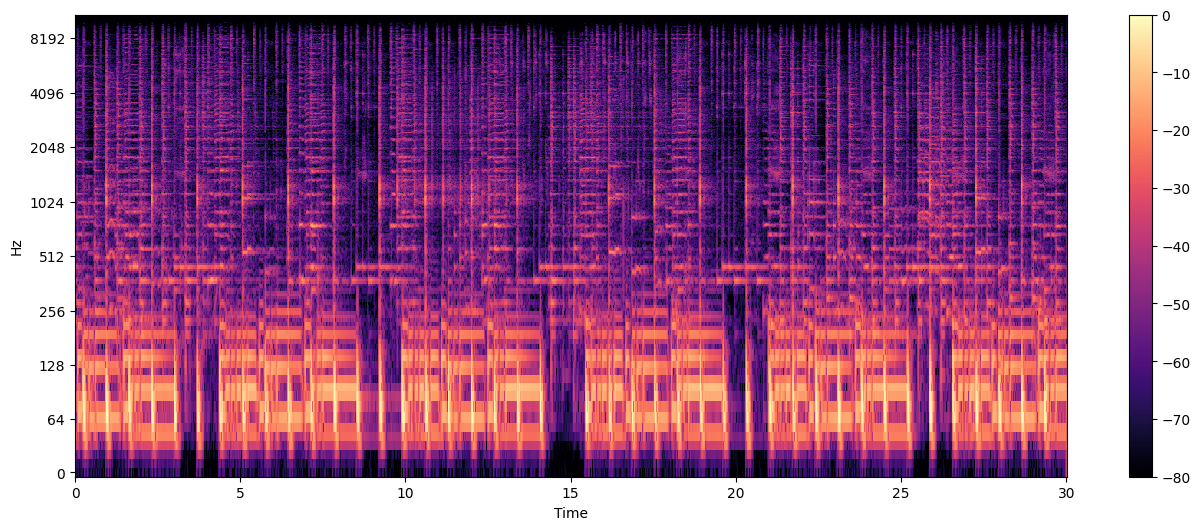

In [5]:
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

## Mel Spectogram

- (인간이 이해하기 힘든) Spectogram의 y축을 Mel Scale로 변환한 것 (Non-linear transformation)
- Mel Scale: https://newsight.tistory.com/294

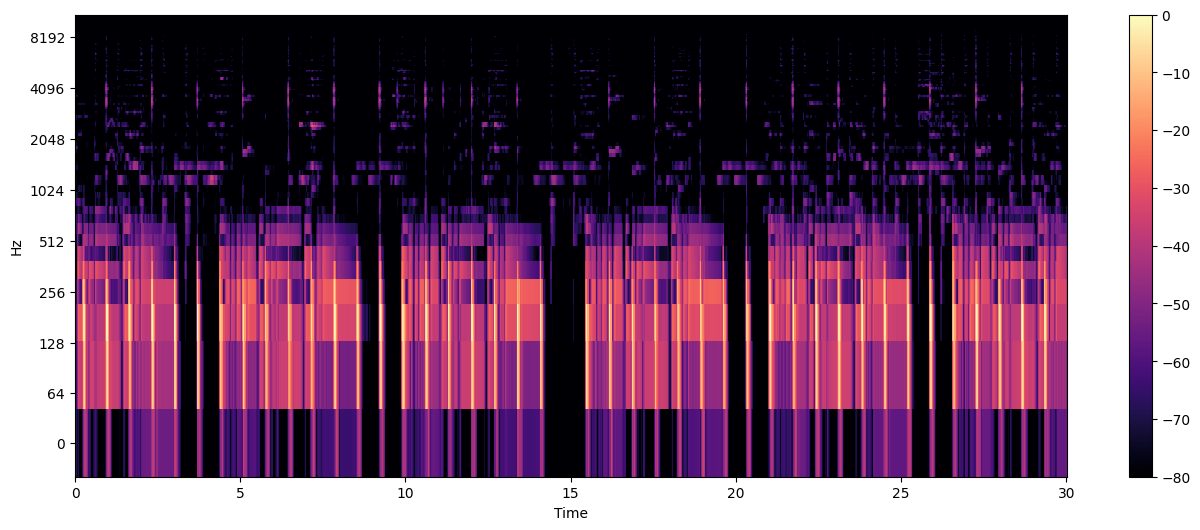

In [6]:
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

## 레게 vs 클래식 Mel Spectogram

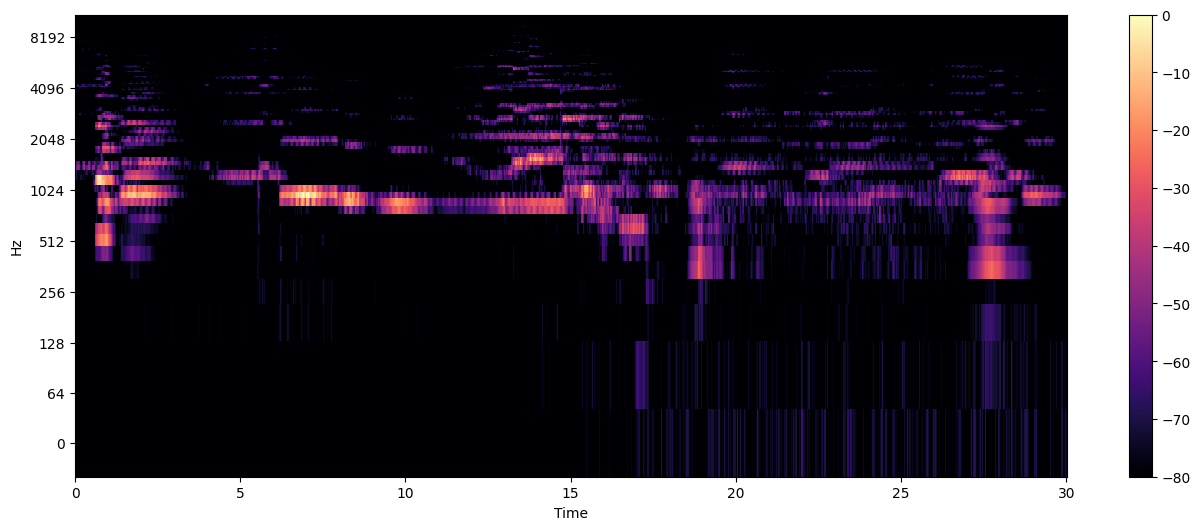

In [7]:
y, sr = librosa.load('Data/genres_original/classical/classical.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis = 'time', y_axis = 'log')
plt.colorbar()
plt.show()

# 오디오 특성 추출 (Audio Feature Extraction)

## Tempo (BPM)

In [8]:
tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
print(tempo)

107.666015625


## Zero Crossing Rate

- 음파가 양에서 음으로 또는 음에서 양으로 바뀌는 비율

In [9]:
zero_crossings = librosa.zero_crossings(y=y, pad=False)

print(zero_crossings)
print(sum(zero_crossings))

[False False False ... False False False]
39405


### 확대해서 보자

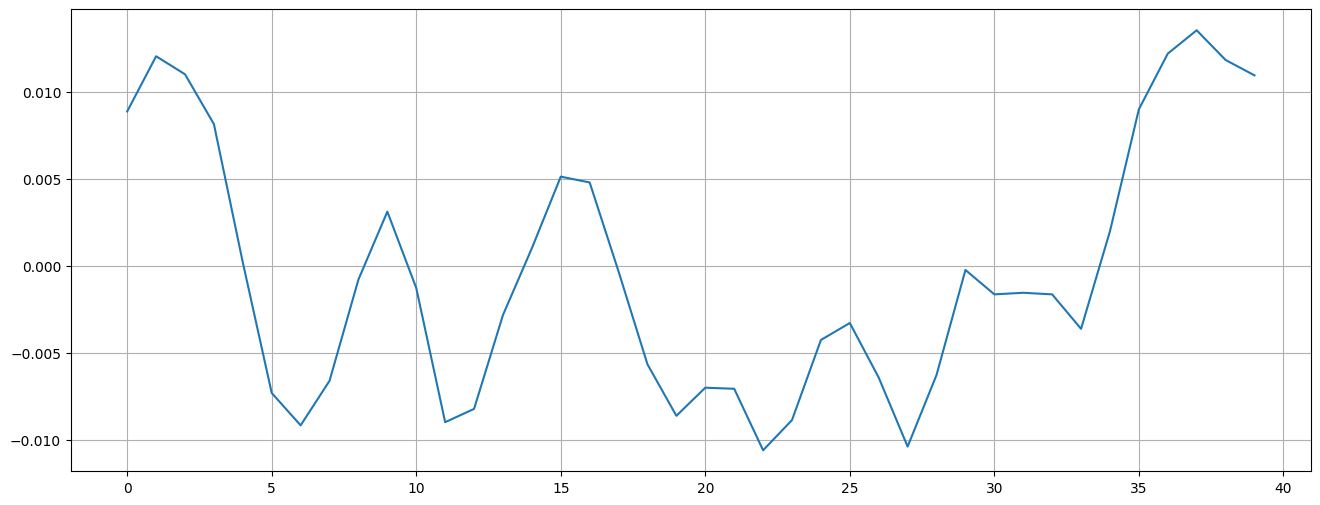

In [10]:
n0 = 9000
n1 = 9040

plt.figure(figsize=(16, 6))
plt.plot(y[n0:n1])
plt.grid()
plt.show()

In [11]:
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
print(sum(zero_crossings))

6


## Harmonic and Percussive Components

- Harmonics: 사람의 귀로 구분할 수 없는 특징들 (음악의 색깔)
- Percussives: 리듬과 감정을 나타내는 충격파

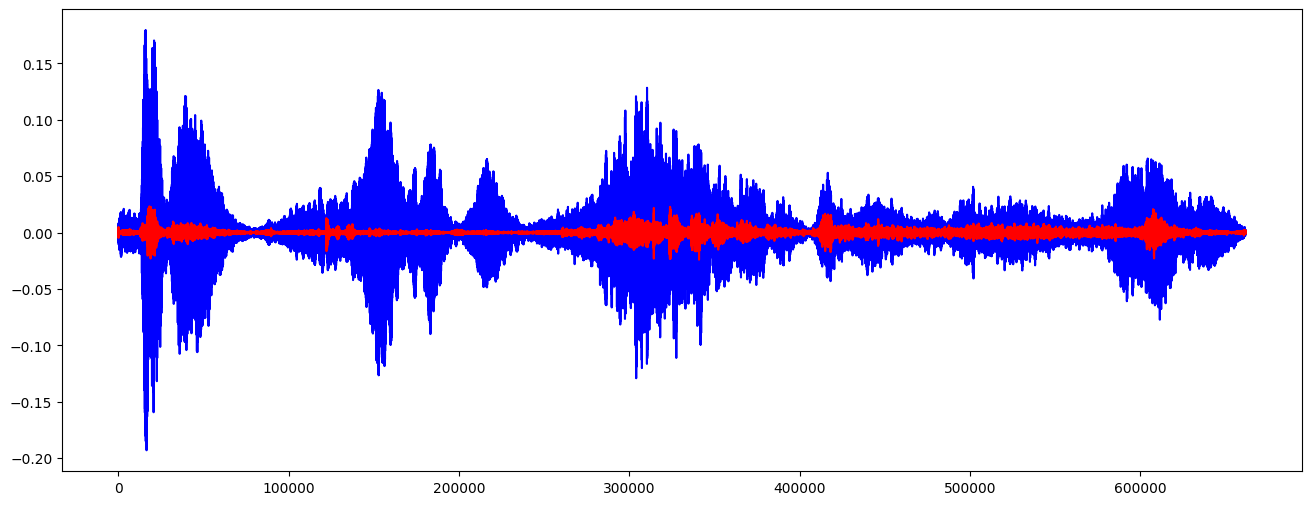

In [12]:
y_harm, y_perc = librosa.effects.hpss(y)

plt.figure(figsize=(16, 6))
plt.plot(y_harm, color='b')
plt.plot(y_perc, color='r')
plt.show()

## Spectral Centroid

- 소리를 주파수 표현했을 때, 주파수의 가중평균을 계산하여 소리의 "무게 중심"이 어딘지를 알려주는 지표
- 예를 들어, 블루스 음악은 무게 중심이 가운데 부분에 놓여있는 반면, 메탈 음악은 (끝 부분에서 달리기 때문에) 노래의 마지막 부분에 무게 중심이 실린다

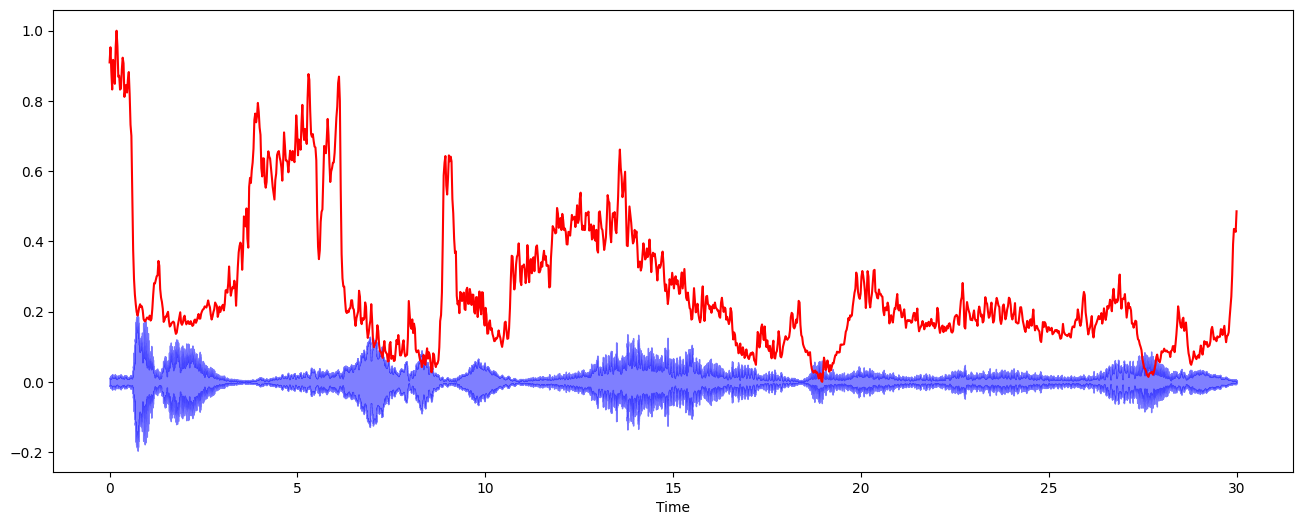

In [13]:
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

import sklearn
def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)

plt.figure(figsize=(16, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()

## Spectral Rolloff

- 신호 모양을 측정한다
- 총 스펙트럴 에너지 중 낮은 주파수(85% 이하)에 얼마나 많이 집중되어 있는가

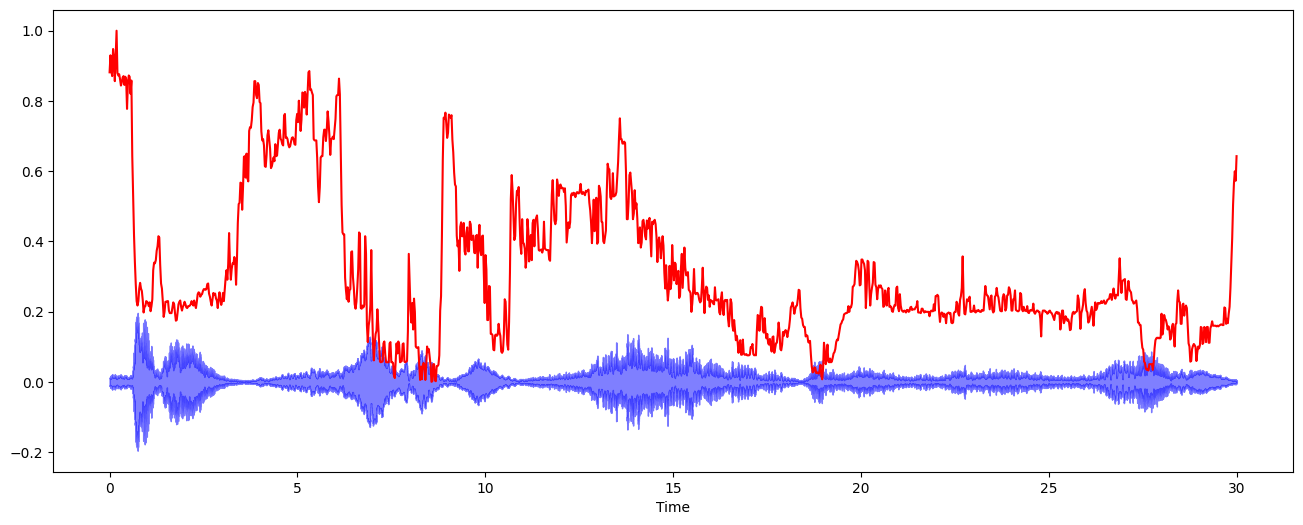

In [14]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

plt.figure(figsize=(16, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.show()

## Mel-Frequency Cepstral Coefficients (MFCCs)

- MFCCs는 특징들의 작은 집합(약 10-20)으로 스펙트럴 포곡선의 전체적인 모양을 축약하여 보여준다
- 사람의 청각 구조를 반영하여 음성 정보 추출
- https://tech.kakaoenterprise.com/66

mean: 0.49
var: 0.04


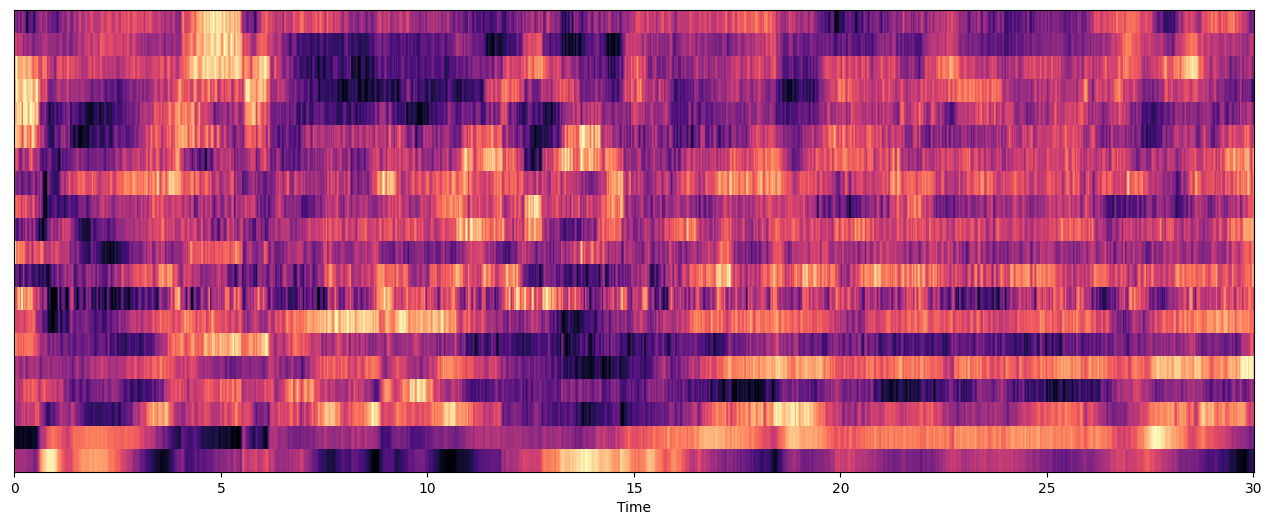

In [15]:
mfccs = librosa.feature.mfcc(y=y, sr=sr)
mfccs = normalize(mfccs, axis=1)

print('mean: %.2f' % mfccs.mean())
print('var: %.2f' % mfccs.var())

plt.figure(figsize=(16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

## Chroma Frequencies

- 크로마 특징은 음악의 흥미롭고 강렬한 표현이다
- 크로마는 인간 청각이 옥타브 차이가 나는 주파수를 가진 두 음을 유사음으로 인지한다는 음악이론에 기반한다
- 모든 스펙트럼을 12개의 Bin으로 표현한다
- 12개의 Bin은 옥타브에서 12개의 각기 다른 반음(Semitones=Chroma)을 의미한다

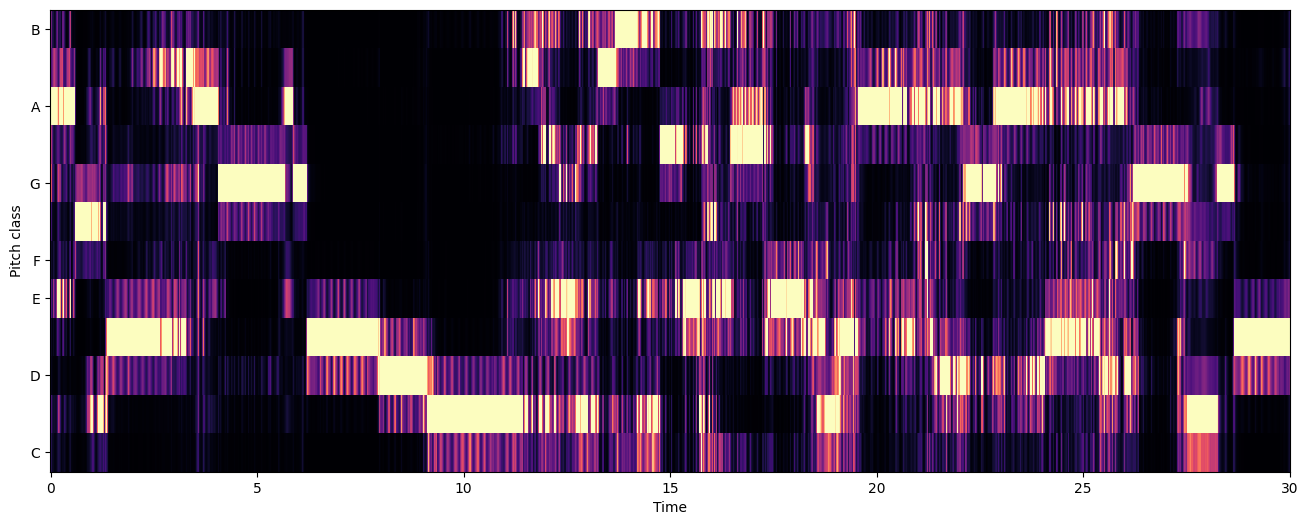

In [16]:
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

# 학습

## 데이터셋 로드

In [26]:
import os
os.cpu_count()

12

In [17]:
import pandas as pd

df = pd.read_csv('Data/features_30_sec.csv')

df.head()

/var/folders/f9/7w3cw7_s6c7849zf1svk37000000gn/T/ipykernel_60942/2987726599.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


## 전처리

In [25]:
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from audio_processing import process_audio

# Assuming df is your DataFrame containing audio file information
rows = [row for _, row in df.iterrows()]
all_features_list = []

with ProcessPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(process_audio, row): row for row in rows}
    
    for future in tqdm(as_completed(futures), total=len(futures)):
        features_list = future.result()
        all_features_list.extend(features_list)

# Now, concatenate all results into a single DataFrame
df_augmented = pd.DataFrame(all_features_list)

  0%|          | 0/1000 [00:05<?, ?it/s]


KeyboardInterrupt: 

/Users/chan/graduation_project/1st_semester/audio_processing.py:79: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/Users/chan/Library/Caches/pypoetry/virtualenvs/1st-semester-ZLCsIA3r-py3.12/lib/python3.12/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
ERROR:audio_processing:Error loading audio file Data/genres_original/jazz/jazz.00054.wav: 


In [ ]:
X = df.drop(columns=['filename', 'length', 'label', 'perceptr_mean', 'perceptr_var'])
y = df['label']

for col in X.columns.to_numpy():
    print(f"max: {np.max(X[col])}, min: {np.min(X[col])} abs max: {np.max(np.abs(X[col])):.12f}, abs min: {np.min(np.abs(X[col])):.12f}")

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(X) # X = train dataset normalize

X = pd.DataFrame(np_scaled, columns=X.columns) # 다시 배치

X.head()

## 데이터셋 분할

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
# 전체 데이터에서 Train:Test = 8:2
# X_train = 학습 데이터 셋의 feature
# X_test =  test 데이터 셋의 feature
# y_train = 학습 데이터 셋의 feature
# y_test =  test 데이터 셋의 feature

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

## 학습 및 검증

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
# n_estimators = 결정트리의 개수
# learning_rate= 최적 지점에 도달하는 속도

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb.fit(X_train, y_train_encoded)

y_preds = xgb.predict(X_test)

print('Accuracy: %.2f' % accuracy_score(y_test_encoded, y_preds))

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_encoded, y_preds)

plt.figure(figsize=(16, 9))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
    yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
)
plt.show()

In [ ]:
for feature, importance in zip(X_test.columns, xgb.feature_importances_):
  print(f"{feature}: {importance: .6f}")

# 사용자 입력 음원 데이터 feature vector 생성

In [ ]:
y, sr = librosa.load("/content/drive/MyDrive/4.5_Oasis.wav", duration=30)
print(y, sr)

In [ ]:
features = {
    'chroma_stft_mean': np.mean(librosa.feature.chroma_stft(y=y, sr=sr)).astype(np.float64),
    'chroma_stft_var': np.var(librosa.feature.chroma_stft(y=y, sr=sr)).astype(np.float64),
    'rms_mean': np.mean(librosa.feature.rms(y=y), axis=1).astype(np.float64),
    'rms_var': np.var(librosa.feature.rms(y=y), axis=1).astype(np.float64),
    'spectral_centroid_mean': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr), axis=1).astype(np.float64),
    'spectral_centroid_var': np.var(librosa.feature.spectral_centroid(y=y, sr=sr), axis=1).astype(np.float64),
    'spectral_bandwidth_mean': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr), axis=1).astype(np.float64),
    'spectral_bandwidth_var': np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr), axis=1).astype(np.float64),
    'rolloff_mean': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr), axis=1).astype(np.float64),
    'rolloff_var': np.var(librosa.feature.spectral_rolloff(y=y, sr=sr), axis=1).astype(np.float64),
    'zero_crossing_rate_mean': np.mean(librosa.feature.zero_crossing_rate(y), axis=1).astype(np.float64),
    'zero_crossing_rate_var': np.var(librosa.feature.zero_crossing_rate(y), axis=1).astype(np.float64),
    'harmony_mean': np.mean(librosa.effects.harmonic(y), axis=0).astype(np.float64),
    'harmony_var': np.var(librosa.effects.harmonic(y), axis=0).astype(np.float64),
    'tempo': librosa.feature.rhythm.tempo(y=y, sr=sr)[0].astype(np.float64),
    'mfcc1_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[0], axis=0).astype(np.float64),
    'mfcc1_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[0], axis=0).astype(np.float64),
    'mfcc2_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[1], axis=0).astype(np.float64),
    'mfcc2_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[1], axis=0).astype(np.float64),
    'mfcc3_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[2], axis=0).astype(np.float64),
    'mfcc3_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[2], axis=0).astype(np.float64),
    'mfcc4_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[3], axis=0).astype(np.float64),
    'mfcc4_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[3], axis=0).astype(np.float64),
    'mfcc5_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[4], axis=0).astype(np.float64),
    'mfcc5_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[4], axis=0).astype(np.float64),
    'mfcc6_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[5], axis=0).astype(np.float64),
    'mfcc6_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[5], axis=0).astype(np.float64),
    'mfcc7_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[6], axis=0).astype(np.float64),
    'mfcc7_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[6], axis=0).astype(np.float64),
    'mfcc8_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[7], axis=0).astype(np.float64),
    'mfcc8_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[7], axis=0).astype(np.float64),
    'mfcc9_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[8], axis=0).astype(np.float64),
    'mfcc9_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[8], axis=0).astype(np.float64),
    'mfcc10_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[9], axis=0).astype(np.float64),
    'mfcc10_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[9], axis=0).astype(np.float64),
    'mfcc11_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[10], axis=0).astype(np.float64),
    'mfcc11_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[10], axis=0).astype(np.float64),
    'mfcc12_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[11], axis=0).astype(np.float64),
    'mfcc12_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[11], axis=0).astype(np.float64),
    'mfcc13_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[12], axis=0).astype(np.float64),
    'mfcc13_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[12], axis=0).astype(np.float64),
    'mfcc14_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[13], axis=0).astype(np.float64),
    'mfcc14_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[13], axis=0).astype(np.float64),
    'mfcc15_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[14], axis=0).astype(np.float64),
    'mfcc15_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[14], axis=0).astype(np.float64),
    'mfcc16_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[15], axis=0).astype(np.float64),
    'mfcc16_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[15], axis=0).astype(np.float64),
    'mfcc17_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[16], axis=0).astype(np.float64),
    'mfcc17_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[16], axis=0).astype(np.float64),
    'mfcc18_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[17], axis=0).astype(np.float64),
    'mfcc18_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[17], axis=0).astype(np.float64),
    'mfcc19_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[18], axis=0).astype(np.float64),
    'mfcc19_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[18], axis=0).astype(np.float64),
    'mfcc20_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[19], axis=0).astype(np.float64),
    'mfcc20_var': np.var(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)[19], axis=0).astype(np.float64),
}


In [ ]:
for i in features.keys():
    if isinstance(features[i], np.ndarray):
        features[i] = np.float64(features[i].item())    # np.ndarray를 np.float64로 맞춰주기
    print(f"{i} : \t\t{type(features[i])}")

# 사용자 입력 음원 확인

In [ ]:
print(y)
print(len(y))
print('Sampling rate (Hz): %d' % sr)
print('Audio length (seconds): %.2f' % (len(y) / sr))

plt.figure(figsize=(16, 6))
librosa.display.waveshow(y=y, sr=sr)
plt.show()

In [ ]:
import IPython.display as ipd

ipd.Audio(y, rate=sr)

In [ ]:
features_df = pd.DataFrame([features])
y_pred = xgb.predict(features_df)
pred_label = label_encoder.inverse_transform(y_pred)
print(pred_label)

# (ADD)간단한 추천 시스템

In [ ]:
df_30 = pd.read_csv('Data/features_30_sec.csv', index_col='filename')

labels_hat = df_30[['label']]
df_30_droped = df_30.drop(columns=['length', 'label', 'perceptr_mean', 'perceptr_var'])

print(df_30_droped.columns)

In [ ]:
df_30_hat = pd.DataFrame(df_30_droped, columns=df_30_droped.columns)
df_y = pd.DataFrame(features, columns=df_30_droped.columns, index=["round_30_secs.wav"])
df_y_label = pd.DataFrame("rock", columns=['label'], index=["round_30_secs.wav"])
labels = pd.concat([df_y_label, labels_hat])

display(df_30_hat)
display(df_y)
display(labels)

In [ ]:
df_30_hat_new = pd.concat([df_y,df_30_hat])
df_30_hat_new.to_csv("Data/new_features.csv", mode='w')

In [ ]:
W = np.array(xgb.feature_importances_).astype(np.float64)
W.T

In [ ]:
df_normalized = pd.DataFrame(normalized_features, columns=features, index=df_30_hat_new.index)
df_normalized.head()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(df_30_hat_new)

sim_df = pd.DataFrame(similarity, index=labels.index, columns=labels.index)

sim_df.head()

In [ ]:
def find_similar_songs(name, n=5):
  series = sim_df[name].sort_values(ascending=False)

  series = series.drop(name)

  return series.head(n).to_frame()

find_similar_songs('round_30_secs.wav')